<a href="https://colab.research.google.com/github/dipasreepoddar/fastbook/blob/master/exercises/full_mnist_further_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [4]:
(path/'training').ls()

(#10) [Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/7')]

In [5]:
(path/'training'/'0').ls().sorted()

(#5923) [Path('/root/.fastai/data/mnist_png/training/0/1.png'),Path('/root/.fastai/data/mnist_png/training/0/1000.png'),Path('/root/.fastai/data/mnist_png/training/0/10005.png'),Path('/root/.fastai/data/mnist_png/training/0/10010.png'),Path('/root/.fastai/data/mnist_png/training/0/10022.png'),Path('/root/.fastai/data/mnist_png/training/0/10025.png'),Path('/root/.fastai/data/mnist_png/training/0/10026.png'),Path('/root/.fastai/data/mnist_png/training/0/10045.png'),Path('/root/.fastai/data/mnist_png/training/0/10069.png'),Path('/root/.fastai/data/mnist_png/training/0/10071.png')...]

In [6]:
digits = range(10)

def loadData(dType, digit):
  '''
  load data of a given type (training/testing) for a given digit
  '''
  data = (path/dType/str(digit)).ls().sorted()
  digit_tensors = [tensor(Image.open(o)) for o in data]
  stacked_digits = torch.stack(digit_tensors).float()/255
  return stacked_digits

trainData = {}
validData = {}
for i in digits:
  trainData[i] = loadData('training', i)
  validData[i] = loadData('testing', i)

In [7]:
# display first image of 8 in training data

df = pd.DataFrame(tensor((trainData[8][0]*255).int()))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,213,195,3,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,211,252,246,54,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,211,252,252,174,0,18,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,213,252,252,197,24,72,209,47,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,207,253,246,117,24,44,235,252,155,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,84,250,250,106,0,72,207,252,252,155,0,0,0,0,0


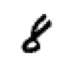

In [8]:
show_image(tensor((trainData[8][0]*255).int()));

# Pixel Similarity Approach

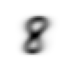

In [9]:
meanDigits = {}
for digit in digits:
  meanDigits[digit] = trainData[digit].mean(0)

def showMeanDigit(digit):
  '''
  Show mean image for a given digit
  '''
  meanDigit = meanDigits[digit]
  show_image(meanDigit);

showMeanDigit(8)

In [10]:
testDigit = validData[8][0]
for i in digits:
  print(F.l1_loss(testDigit.float(),meanDigits[i]), F.mse_loss(testDigit,meanDigits[i]).sqrt())

tensor(0.1780) tensor(0.3066)
tensor(0.0915) tensor(0.2254)
tensor(0.1468) tensor(0.2538)
tensor(0.1266) tensor(0.2325)
tensor(0.1306) tensor(0.2476)
tensor(0.1222) tensor(0.2202)
tensor(0.1392) tensor(0.2575)
tensor(0.1194) tensor(0.2386)
tensor(0.1124) tensor(0.2013)
tensor(0.1140) tensor(0.2216)


In [11]:
def mnist_l1_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_l1_distance(testDigit, meanDigits[8])

tensor(0.1124)

In [12]:
def mnist_rmse_distance(a,b): return ((a-b)**2).mean((-1,-2)).sqrt()
mnist_rmse_distance(testDigit, meanDigits[8])

tensor(0.2013)

In [13]:
def predict_digit_l1(x): 
  distTens = torch.stack([mnist_l1_distance(x,meanDigits[i]) for i in digits])
  return torch.argmin(distTens,0)

predict_digit_l1(validData[8][0:20])

tensor([1, 8, 1, 1, 1, 9, 1, 8, 8, 1, 9, 8, 1, 1, 9, 9, 9, 9, 4, 1])

In [14]:
def predict_digit_rmse(x): 
  distTens = torch.stack([mnist_rmse_distance(x,meanDigits[i]) for i in digits])
  return torch.argmin(distTens,0)

predict_digit_rmse(validData[8][:20])

tensor([8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 2, 8, 8, 1, 9, 8, 8, 9, 4, 5])

In [15]:
# Calculate the L1 prdiction accuracies
accuracies_l1 = [(predict_digit_l1(validData[i])==i).float().mean() for i in digits]
accuracies_l1, torch.stack(accuracies_l1).mean()

([tensor(0.8153),
  tensor(0.9982),
  tensor(0.4234),
  tensor(0.6089),
  tensor(0.6680),
  tensor(0.3262),
  tensor(0.7871),
  tensor(0.7646),
  tensor(0.4425),
  tensor(0.7760)],
 tensor(0.6610))

In [16]:
# Calculate the RMSE prdiction accuracies
accuracies_rmse = [(predict_digit_rmse(validData[i])==i).float().mean() for i in digits]
accuracies_rmse, torch.stack(accuracies_rmse).mean()

([tensor(0.8959),
  tensor(0.9621),
  tensor(0.7568),
  tensor(0.8059),
  tensor(0.8259),
  tensor(0.6861),
  tensor(0.8633),
  tensor(0.8327),
  tensor(0.7372),
  tensor(0.8067)],
 tensor(0.8173))

# ML approach

In [17]:
train_x = torch.cat([trainData[i] for i in digits]).view(-1, 28*28)
train_x.shape

torch.Size([60000, 784])

In [18]:
train_y = torch.cat([tensor([i]*len(trainData[i])) for i in digits]).unsqueeze(1)
train_y.shape

torch.Size([60000, 1])

In [19]:
train_dset = list(zip(train_x,train_y))
x,y = train_dset[0]
x.shape,y

(torch.Size([784]), tensor([0]))

In [20]:
valid_x = torch.cat([validData[i] for i in digits]).view(-1, 28*28)
valid_y = torch.cat([tensor([i]*len(validData[i])) for i in digits]).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [21]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [22]:
dls = DataLoaders(train_dl, valid_dl)

In [23]:
def myloss(predictions, targets):
  sm = torch.log_softmax(predictions, dim=1)
  idx = tensor(range(len(targets)))
  return F.nll_loss(sm, targets.squeeze())

In [24]:
def mycrossentropy(predictions, targets):
  return F.cross_entropy(predictions, targets.squeeze())

In [25]:
def myaccuracy(predictions, targets):
  pred_nums = torch.argmax(predictions, axis=1)
  return (pred_nums==targets.T).float().mean()

In [26]:
simple_net1 = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 10)
)
simple_net2 = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [27]:
learn1 = Learner(dls, simple_net1, loss_func=myloss, opt_func=SGD, metrics=myaccuracy)

In [28]:
# For testing
# testx, testy = dls.one_batch()
# preds1,_ = learn1.get_preds(dl=[(testx, testy)])
# myaccuracy(preds1, testy).item()

In [32]:
learn1.fit(n_epoch=40, lr=0.05)

epoch,train_loss,valid_loss,myaccuracy,time
0,0.678680,0.529240,0.871300,00:01
1,0.431554,0.383428,0.894900,00:01
2,0.372950,0.340310,0.905300,00:01
3,0.326341,0.316911,0.911000,00:01
4,0.313345,0.301990,0.916300,00:01
5,0.309579,0.290029,0.920600,00:01
6,0.293822,0.280053,0.923600,00:01
7,0.285737,0.271388,0.924100,00:01
8,0.280265,0.264654,0.926400,00:01
9,0.262926,0.259319,0.928000,00:01


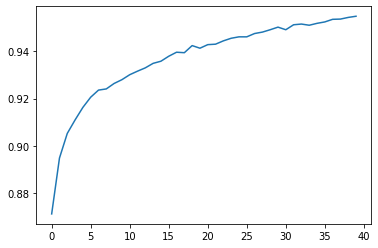

In [33]:
plt.plot(L(learn1.recorder.values).itemgot(2));

In [34]:
learn2 = Learner(dls, simple_net2, loss_func=mycrossentropy, opt_func=SGD, metrics=myaccuracy)

In [35]:
preds2,_ = learn2.get_preds(dl=[(testx, testy)])
preds2

tensor([[ 0.0702, -0.0511, -0.2038,  ..., -0.1483,  0.0471, -0.1220],
        [ 0.0877, -0.0457, -0.3911,  ..., -0.0948,  0.0124, -0.1959],
        [ 0.0155, -0.0222, -0.2307,  ..., -0.1603,  0.1120, -0.1523],
        ...,
        [ 0.1837, -0.0458, -0.2557,  ..., -0.1210,  0.0903, -0.1954],
        [ 0.1311, -0.0771, -0.2237,  ..., -0.1979,  0.0881, -0.0167],
        [ 0.0745, -0.0680, -0.2172,  ..., -0.1744,  0.0916, -0.0853]])

In [36]:
myaccuracy(preds2, testy).item()

0.10546875

In [37]:
learn2.fit(n_epoch=40, lr=0.05)

epoch,train_loss,valid_loss,myaccuracy,time
0,0.708319,0.548911,0.865300,00:01
1,0.433415,0.393620,0.892100,00:01
2,0.374179,0.348087,0.902500,00:01
3,0.347135,0.322505,0.908900,00:01
4,0.321868,0.306745,0.912300,00:01
5,0.314830,0.297396,0.915600,00:01
6,0.299297,0.287254,0.918800,00:01
7,0.290569,0.282146,0.919400,00:01
8,0.283823,0.277977,0.922700,00:01
9,0.277369,0.269445,0.925300,00:01


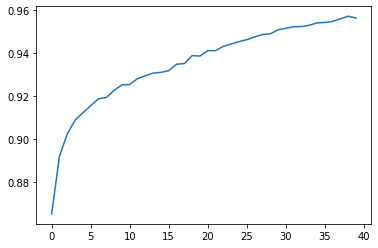

In [38]:
plt.plot(L(learn2.recorder.values).itemgot(2));